RL109 - t011
- all optical
- pre 4ap

t11 - photostim experiment #3 (NAPARM export: 2020-12-19_RL109_ps_012); 	
9 cells x 4 groups; 5mW per cell

preset: 2020-11-25_PS_250ms-stim-50hz (approach #1)

change every: 250ms

shots per pattern: 10

inter-shot interval (ms): 25

spiral duration (ms): 20

delay first spiral (ms): 5

trial length (s): 5

number of trials: 100

paq: 2020-12-19_RL109_010.paq


## RL109 - t011 - alloptical photostim processing

In [1]:
import sys; sys.path.append('/home/pshah/Documents/code/PackerLab_pycharm/')
import os
import pickle
import alloptical_utils_pj as aoutils
import alloptical_plotting as aoplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils.funcs_pj as pj

###### IMPORT pkl file containing expobj
trial = 't-011'
date = '2020-12-19'
pkl_path = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)

expobj, experiment = aoutils.import_expobj(trial=trial, date=date, pkl_path=pkl_path)

cont_inue = True  # i know this is a rather very precarious thing here...

s2p_path = '/home/pshah/mnt/qnap/Analysis/2020-12-19/suite2p/alloptical-2p-1x-alltrials/plane0'  # (most recent run for RL108 -- contains all trials including post4ap all optical trials)

print('\nExperiment information:\n', expobj.metainfo)

importing expobj for "2020-12-19, t-011" from: /home/pshah/mnt/qnap/Analysis/2020-12-19/2020-12-19_t-011/2020-12-19_t-011.pkl
DONE IMPORT of RL109: t-011, pre 4ap 2p all optical

Experiment information:
 {'animal prep.': 'RL109', 'trial': 't-011', 'date': '2020-12-19', 'exptype': 'pre 4ap 2p all optical', 'data_path_base': '/home/pshah/mnt/qnap/Data/2020-12-19', 'comments': 'photostim: 9 cells x 4 groups; 5mW per cell; preset: 2020-11-25_PS_250ms-stim-50hz (approach #1); clumps of cells fired together - classic_naparm style'}


Loading 561 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7

searching for targeted cells...
(255, 242)
(250, 424)
(267, 311)
(226, 369)
(276, 233)
(286, 235)
(189, 278)
(256, 250)
(192, 287)
------- Search completed.
Number of targeted cells:  9
Target cells found in suite2p:  [52, 96, 130, 226, 377, 429, 512, 574, 738]  -- 9 cells (out of 36 target coords)


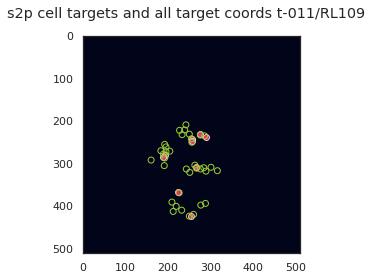

Retrieving s2p masks for: /home/pshah/mnt/qnap/Analysis/2020-12-19/2020-12-19_t-011/2020-12-19_t-011.pkl              
s2p ROI + photostim targets masks saved to:  /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-19_t-011_s2p_masks.tif


In [2]:
# %% prep for importing data from suite2p for this whole experiment
# determine which frames to retrieve from the overall total s2p output
trials = ['t-005', 't-006', 't-007', 't-008', 't-011', 't-012', 't-013', 't-014', 't-016',
              't-017', 't-018', 't-019', 't-020', 't-021']  # specify all trials that were used in the suite2p run
baseline_trials = ['t-005', 't-006']  # specify which trials to use as spont baseline
# note ^^^ this only works currently when the spont baseline trials all come first, and also back to back
total_frames_stitched = 0
curr_trial_frames = None
baseline_frames = [0, 0]
for t in trials:
    pkl_path_2 = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, t, date, t)
    with open(pkl_path_2, 'rb') as f:
        _expobj = pickle.load(f)
        # import suite2p data
    total_frames_stitched += _expobj.n_frames
    if t == trial:
        expobj.curr_trial_frames = [total_frames_stitched - _expobj.n_frames, total_frames_stitched]
    if t in baseline_trials:
        baseline_frames[1] = total_frames_stitched



# suite2p processing on expobj; import suite2p data, flu, spks, cell coordinates and make s2p masks images stack
# s2p_path = '/Users/prajayshah/Documents/data-to-process/2020-12-18/suite2p/alloptical-2p-pre-4ap-08x/plane0'
# flu, spks, stat = uf.s2p_loader(s2p_path, subtract_neuropil=True)


# s2p_path = '/Volumes/Extreme SSD/oxford-data/2020-03-18/suite2p/photostim-4ap_stitched/plane0'

# main function that imports suite2p data and adds attributes to the expobj
expobj.s2pProcessing(s2p_path=s2p_path, subset_frames=expobj.curr_trial_frames, subtract_neuropil=True,
                     baseline_frames=baseline_frames)

expobj.target_coords_all = expobj.target_coords
expobj.s2p_targets()

# expobj.target_coords_all = expobj.target_coords

# flu, expobj.spks, expobj.stat = uf.s2p_loader(s2p_path, subtract_neuropil=True)

aoutils.s2pMaskStack(obj=expobj, pkl_list=[pkl_path], s2p_path=s2p_path,
                     parent_folder='/home/pshah/mnt/qnap/Analysis/2020-12-18/')


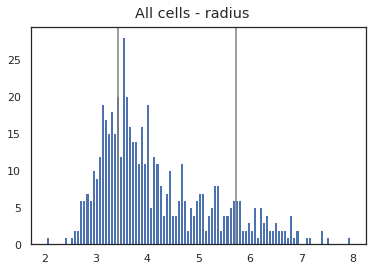

In [3]:
# %% plotting the distribution of radius and aspect ratios - should this be running before the filtering step which is right below????????

radius_list = aoplot.plot_cell_radius_aspectr(expobj, expobj.stat, to_plot='radius')

In [4]:
# %% FILTER ALL CELLS THAT ARE ACTIVE AT LEAST ONCE FOR >2.5*std

# pull out needed variables because numba doesn't work with custom classes (such as this all-optical class object)
cell_ids = expobj.cell_id
raws = expobj.raw
# expobj.append_seizure_frames(bad_frames=None)
photostim_frames = expobj.photostim_frames
radiuses = expobj.radius

# initial quick run to allow numba to compile the function - not sure if this is actually creating time savings
_ = aoutils._good_cells(cell_ids=cell_ids[:3], raws=raws, photostim_frames=expobj.photostim_frames, radiuses=radiuses,
                        std_thresh=2, min_radius_pix=2.5, max_radius_pix=8.5)
expobj.good_cells = aoutils._good_cells(cell_ids=cell_ids, raws=raws, photostim_frames=expobj.photostim_frames,
                                        radiuses=radiuses,
                                        std_thresh=2, min_radius_pix=2.5, max_radius_pix=8.5)


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_utils_pj.py:1870: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function 'np_asarray.<locals>.impl'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../anaconda3/envs/2021/lib/python3.8/site-packages/numba/np/arraymath.py", line 3873:
        if is_nonelike(dtype):
            def impl(a, dtype=None):
            ^

  raw_ = np.delete(raw, photostim_frames)
/home/pshah/Documents/code/PackerLab_pycharm/alloptical_utils_pj.py:1870: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'obj' of function 'np_delete.<locals>.np_delete_impl'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.htm

0  out of  3  cells done
# of good cells found:  3  (out of  3  ROIs)
0  out of  561  cells done
100  out of  561  cells done
200  out of  561  cells done
300  out of  561  cells done
400  out of  561  cells done
500  out of  561  cells done
# of good cells found:  524  (out of  561  ROIs)


In [5]:
# %% SAVE THE UPDATED expobj OBJECT IN THE ORIGINAL PKL PATH TO USE NEXT

# make the necessary Analysis saving subfolder as well
expobj.analysis_save_path = expobj.tiff_path[:21] + 'Analysis/' + expobj.tiff_path[26:-35]
if os.path.exists(expobj.analysis_save_path):
    pass
elif os.path.exists(expobj.analysis_save_path[:-17]):
    os.mkdir(expobj.analysis_save_path)
elif os.path.exists(expobj.analysis_save_path[:-27]):
    os.mkdir(expobj.analysis_save_path[:-17])


expobj.save_pkl(pkl_path=pkl_path)


print("\n COMPLETED RUNNING ALL OPTICAL PROCESSING PHOTOSTIM.")


pkl saved to /home/pshah/mnt/qnap/Analysis/2020-12-19/2020-12-19_t-011/2020-12-19_t-011.pkl

 COMPLETED RUNNING ALL OPTICAL PROCESSING PHOTOSTIM.


#### processing steps for ALL OPTICAL PHOTOSTIM related stuff

In [6]:
# %% Collect pre to post stim traces for PHOTOSTIM TARGETED CELLS, FILTER FOR GOOD PHOTOSTIM. TARGETED CELLS with responses above threshold = 1 std of the prestim std

expobj.pre_stim = 15  # specify pre-stim and post-stim periods of analysis and plotting
expobj.post_stim = 150

# function for gathering all good photostim cells who respond on average across all trials to the photostim
# note that the threshold for this is 1 * std of the prestim raw flu (fluorescence trace)
expobj.targets_dff, expobj.targets_dff_avg, expobj.targets_dfstdF, \
    expobj.targets_dfstdF_avg, expobj.targets_raw, expobj.targets_raw_avg = \
    aoutils.get_targets_stim_traces_norm(expobj=expobj, normalize_to='pre-stim', pre_stim=expobj.pre_stim,
                                         post_stim=expobj.post_stim)

aoutils._good_photostim_cells(expobj=expobj, pre_stim=expobj.pre_stim, post_stim=expobj.post_stim, dff_threshold=None)

# what does threshold value mean? add more descriptive print output for that

# Collect pre to post stim traces for NON-TARGETS

expobj.dff_traces, expobj.dff_traces_avg, expobj.dfstdF_traces, \
    expobj.dfstdF_traces_avg, expobj.raw_traces, expobj.raw_traces_avg = \
    aoutils.get_nontargets_stim_traces_norm(expobj=expobj, normalize_to='pre-stim', pre_stim=expobj.pre_stim,
                                            post_stim=expobj.post_stim)


Cell #52 - dFF post-stim: 13.293171 (threshold value = 2.4045353730519707)
Cell #96 - dFF post-stim: 12.092711 (threshold value = 7.266536204020181)
Cell #130 - dFF post-stim: 32.329823 (threshold value = 4.202337066332504)
Cell #226 - dFF post-stim: 21.711817 (threshold value = 4.70204140345254)
Cell #377 - dFF post-stim: 12.355449 (threshold value = 3.3256302833557356)
Cell #512 - dFF post-stim: 43.7773 (threshold value = 5.249564639727282)
Cell #574 - dFF post-stim: 28.097727 (threshold value = 2.533781496683755)
Cell #738 - dFF post-stim: 15.986546 (threshold value = 6.234208838144923)
[std threshold of 1 std]
|- 8 cells out of 8 s2p target cells photostim. responses above threshold
|- Total number of good photostim responsive cells found: 8 (out of 8 s2p photostim target cells)

Completed collecting pre to post stim traces -- normalized to pre-stim stdF -- for 516 cells


In [7]:
#%% turn important cell x time arrays into pandas dataframes

# raw Flu traces of all good cells
columns = [f'{num}' for num in range(expobj.curr_trial_frames[0], expobj.curr_trial_frames[1])]
index = [f'{num}' for num in expobj.good_cells]
idxs = [expobj.cell_id.index(cell) for cell in expobj.good_cells]
expobj.raw_df = pd.DataFrame(expobj.raw[idxs, :], columns=columns, index=index)


# raw baseline Flu traces of all good cells
columns = [f'{num}' for num in range(baseline_frames[0], baseline_frames[1])]
index = [f'{num}' for num in expobj.good_cells]
idxs = [expobj.cell_id.index(cell) for cell in expobj.good_cells]
expobj.baseline_raw_df = pd.DataFrame(expobj.baseline_raw[idxs, :], columns=columns, index=index)



In [8]:
# %% calculate dFF responses of all cells to photostimulation trials expobj

# non-targeted cells: calculate response of non-targeted cells in response to photostim. trials
# - make a pandas dataframe that contains the post-stim response of all cells at each stim timepoint
#   give group name 'non_targets' to the non-targetted cells, and the appropriate SLM group number to targetted cells


expobj.dff_responses_all_cells = aoutils.all_cell_responses_dff(expobj, normalize_to='pre-stim')

# calculate the avg response values for all cells across all stims
average_responses = np.mean(expobj.dff_responses_all_cells[expobj.dff_responses_all_cells.columns[1:]], axis=1)
responses = {'cell_id': [], 'group': [], 'Avg. dFF response': []}
for cell in expobj.good_cells:
    if cell in expobj.s2p_cell_targets:
        responses['cell_id'].append(cell)
        responses['group'].append('photostim target')
        responses['Avg. dFF response'].append(average_responses[cell])
    else:
        responses['cell_id'].append(cell)
        responses['group'].append('non-target')
        responses['Avg. dFF response'].append(average_responses[cell])

expobj.average_responses_df = pd.DataFrame(responses)

print('\nThe avg. dF/F responses of photostim targets is: %s' % np.mean(
    expobj.average_responses_df[expobj.average_responses_df.group == 'photostim target'])[1])


Completed gathering dFF responses to photostim for 525 cells
risky cells (with low Flu values to normalize with):  [20, 147, 165, 178, 197, 203, 217, 247, 253, 268, 276, 284, 290, 299, 353, 365, 404, 411, 423, 429, 439, 459, 477, 489, 519, 528, 530, 531, 568, 578, 585, 586, 605, 664, 691, 697, 764, 765, 771, 795, 829, 861, 881, 937, 944, 946, 1037, 1055, 1061, 1066, 1099, 1104, 1189, 1199, 1203, 1220, 1221, 1227, 1228]

The avg. dF/F responses of photostim targets is: 22.455560455322264


In [9]:
# %% calculate dF_stdF responses of all cells to photostimulation trials expobj

expobj.dfstdf_all_cells = aoutils.all_cell_responses_dFstdF(expobj)

# calculate the avg response values for all cells across all stims
average_responses_dfstdf = np.mean(expobj.dfstdf_all_cells[expobj.dfstdf_all_cells.columns[1:]], axis=1)
responses = {'cell_id': [], 'group': [], 'Avg. dF/stdF response': []}
for cell in expobj.good_cells:
    if cell in expobj.s2p_cell_targets:
        responses['cell_id'].append(cell)
        responses['group'].append('photostim target')
        responses['Avg. dF/stdF response'].append(average_responses_dfstdf[cell])
    else:
        responses['cell_id'].append(cell)
        responses['group'].append('non-target')
        responses['Avg. dF/stdF response'].append(average_responses_dfstdf[cell])

expobj.average_responses_dfstdf = pd.DataFrame(responses)

print('\nThe avg. dF/stdF responses of photostim targets is: %s' % np.mean(
    expobj.average_responses_dfstdf[expobj.average_responses_dfstdf.group == 'photostim target'])[1])

expobj.save()

Completed gathering dF/stdF responses to photostim for 525 cells

The avg. dF/stdF responses of photostim targets is: 0.7188897228240967
pkl saved to /home/pshah/mnt/qnap/Analysis/2020-12-19/2020-12-19_t-011/2020-12-19_t-011.pkl


In [10]:
sys.exit()

SystemExit: 

/home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## alloptical photostim analysis - t-011

trials: ['t-011'] -- pre 4ap all optical

naparm export: 2020-12-19_RL109_ps_012 --multi

In [ ]:
# %% IMPORT MODULES AND TRIAL expobj OBJECT
import sys

sys.path.append('/home/pshah/Documents/code/PackerLab_pycharm/')
sys.path.append('/home/pshah/Documents/code/')
import alloptical_utils_pj as aoutils
import alloptical_plotting as aoplot
import utils.funcs_pj as pj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import draw

###### IMPORT pkl file containing data in form of expobj
trial = 't-007'
date = '2020-12-19'
pkl_path = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)
# pkl_path = "/home/pshah/mnt/qnap/Data/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)

expobj, experiment = aoutils.import_expobj(trial=trial, date=date, pkl_path=pkl_path)


In [ ]:
# %% PLOT AVG PHOTOSTIM PRE- POST- TRACE AVGed OVER ALL PHOTOSTIM. TRIALS - PHOTOSTIM TARGETTED cells

# x = np.asarray([i for i in expobj.good_photostim_cells_stim_responses_dFF[0]])
x = np.asarray([i for i in expobj.targets_dfstdF_avg])
# y_label = 'pct. dFF (normalized to prestim period)'
y_label = 'dFstdF (normalized to prestim period)'

aoplot.plot_photostim_avg(dff_array=x, expobj=expobj, stim_duration=expobj.duration_frames, pre_stim=expobj.pre_stim,
                          post_stim=expobj.post_stim,
                          title=(experiment + '- responses of all photostim targets'),
                          y_label=y_label, x_label='Time post-stimulation (seconds)')


In [ ]:
# %% PLOT ENTIRE TRIAL - targeted cells plotted individually as subplots

expobj.raw_targets = [expobj.raw[expobj.cell_id.index(i)] for i in expobj.s2p_cell_targets]
expobj.dff_targets = aoutils.normalize_dff(np.array(expobj.raw_targets))
# expobj.targets_dff_base = aoutils.normalize_dff_baseline(
#     arr=expobj.raw_df.loc[[str(x) for x in expobj.s2p_cell_targets]],
#     baseline_array=expobj.baseline_raw_df)
# plot_photostim_subplots(dff_array=dff_targets,
#                 title=(experiment + '%s responses of responsive cells' % len(expobj.good_photostim_cells_stim_responses_dFF)))
to_plot = expobj.dff_targets


aoplot.plot_photostim_overlap_plots(dff_array=to_plot, expobj=expobj,
                                    y_lims=[0, 5000], title=(experiment + '-'))

aoplot.plot_photostim_subplots(dff_array=to_plot, expobj=expobj, x_label='Frames',
                               y_label='Raw Flu',
                               title=(experiment))


In [ ]:
# %% RELIABILITY MEASUREMENTS and PLOT - PHOTOSTIM TARGETED CELLS
# measure, for each cell, the pct of trials in which the dFF > 20% post stim (normalized to pre-stim avgF for the trial and cell)
# can plot this as a bar plot for now showing the distribution of the reliability measurement

expobj.reliability = aoutils.calculate_reliability(expobj=expobj, dfstdf_threshold=0.3)
pj.bar_with_points(data=[list(expobj.reliability.values())], x_tick_labels=['t-013'], ylims=[0, 100], bar=False,
                   title='%s reliability of stim responses' % trial, expand_size_x=2)


In [ ]:
# %% PLOT AVG PHOTOSTIM PRE- POST- TRACE AVGed OVER ALL PHOTOSTIM. TRIALS - NON - TARGETS
x = np.asarray([i for i in expobj.dfstdF_traces_avg])
# y_label = 'pct. dFF (normalized to prestim period)'
y_label = 'dFstdF (normalized to prestim period)'

aoplot.plot_photostim_avg(dff_array=x, expobj=expobj, stim_duration=expobj.duration_frames, pre_stim=expobj.pre_stim,
                          post_stim=expobj.post_stim,
                          title=(experiment + '- responses of all photostim targets'),
                          y_label=y_label, x_label='Time post-stimulation (seconds)')

In [ ]:
# %% PLOT HEATMAP OF AVG PRE- POST TRACE AVGed OVER ALL PHOTOSTIM. TRIALS - ALL CELLS (photostim targets at top) - Lloyd style :D

x = np.asarray([i for i in expobj.targets_dfstdF_avg])
aoplot.plot_traces_heatmap(x, vmin=-1, vmax=1, stim_on=expobj.pre_stim, stim_off=expobj.pre_stim + expobj.duration_frames - 1,
                           title=(experiment + ' - targets only'))

x = np.asarray([i for i in expobj.dfstdF_traces_avg])
aoplot.plot_traces_heatmap(x, vmin=-0.5, vmax=0.5, stim_on=expobj.pre_stim, stim_off=expobj.pre_stim + expobj.duration_frames - 1,
                           title=(experiment + ' - nontargets'))


In [ ]:
# %% BAR PLOT PHOTOSTIM RESPONSES SIZE - TARGETS vs. NON-TARGETS
# collect photostim timed average dff traces
all_cells_dff = []
good_std_cells = []


## using pj.bar_with_points() for a nice bar graph
group1 = list(expobj.average_responses_dfstdf[expobj.average_responses_dfstdf['group'] == 'photostim target'][
                  'Avg. dF/stdF response'])
group2 = list(
    expobj.average_responses_dfstdf[expobj.average_responses_dfstdf['group'] == 'non-target']['Avg. dF/stdF response'])
pj.bar_with_points(data=[group1, group2], x_tick_labels=['photostim target', 'non-target'], xlims=[0, 0.6],
                   ylims=[0, 1.5], bar=False,
                   colors=['red', 'black'], title=experiment, y_label='Avg dF/stdF response', expand_size_y=1.3,
                   expand_size_x=1.4)


In [ ]:
# %% PLOT HEATMAP OF PHOTOSTIM. RESPONSES TO PHOTOSTIM FOR ALL CELLS
# - need to find a way to sort these responses that similar cells are sorted together
# - implement a heirarchical clustering method

stim_timings = [str(i) for i in expobj.stim_start_frames]  # need each stim start frame as a str type for pandas slicing

# make heatmap of responses across all cells across all stims
df_ = expobj.dfstdf_all_cells[stim_timings]  # select appropriate stim time reponses from the pandas df
df_ = df_[df_.columns].astype(float)

plt.figure(figsize=(5, 15));
sns.heatmap(df_, cmap='seismic', vmin=-5, vmax=5, cbar_kws={"shrink": 0.25});
plt.show()


In [ ]:
# %% PLOT imshow() XY locations with COLORS AS average response of ALL cells in FOV
aoplot.xyloc_responses(expobj, to_plot='dfstdf', clim=[-0.5, +0.5], plot_target_coords=True)
